In [1]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1k-5T94gSMs5d0Oq1nbR7ZAARWpOp7sfh' -O 'cleaned_data.csv'

--2022-12-30 10:19:35--  https://drive.google.com/uc?export=download&id=1k-5T94gSMs5d0Oq1nbR7ZAARWpOp7sfh
Resolving drive.google.com (drive.google.com)... 173.194.214.100, 173.194.214.102, 173.194.214.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.214.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mpp6v1p744lfesnnehefe7drp9525s8q/1672395525000/15909033177498261227/*/1k-5T94gSMs5d0Oq1nbR7ZAARWpOp7sfh?e=download&uuid=2651da89-9d2c-4ec5-88dd-c731501d0e88 [following]
--2022-12-30 10:19:36--  https://doc-00-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mpp6v1p744lfesnnehefe7drp9525s8q/1672395525000/15909033177498261227/*/1k-5T94gSMs5d0Oq1nbR7ZAARWpOp7sfh?e=download&uuid=2651da89-9d2c-4ec5-88dd-c731501d0e88
Resolving doc-00-5k-docs.googleusercontent.com (doc-00-5k-docs.googleusercontent.com)... 74.125.134.132, 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)


### 1. Find best method to address the imbalance
1. Under sampling
2. Over sampling
3. SMOTE

### 2. train_test_split

### 3. Models to try
1. Logistic Regression
2. SVM
3. Bagging with Decision Tree
4. Random Forest Classifier
5. Naive Bayes

### 4. Find best parameter and model

In [3]:
df = pd.read_csv('./cleaned_data.csv')
df.head()

,age,gender,air_pollution,alcohol_use,dust_allergy,occupational_hazards,genetic_risk,chronic_lung_disease,balanced_diet,obesity,smoking,passive_smoker,chest_pain,coughing_of_blood,fatigue,weight_loss,shortness_of_breath,wheezing,swallowing_difficulty,clubbing_of_finger_nails,frequent_cold,dry_cough,snoring,level
0,33,1,2,4,5,4,3,2,2,4,3,2,2,4,3,4,2,2,3,1,2,3,4,0
1,17,1,3,1,5,3,4,2,2,2,2,4,2,3,1,3,7,8,6,2,1,7,2,1
2,35,1,4,5,6,5,5,4,6,7,2,3,4,8,8,7,9,2,1,4,6,7,2,2
3,37,1,7,7,7,7,6,7,7,7,7,7,7,8,4,2,3,1,4,5,6,7,5,2
4,46,1,6,8,7,7,7,6,7,7,8,7,7,9,3,2,4,1,4,2,4,2,3,2


In [4]:
df['level'].value_counts()

2    365
1    332
0    303
Name: level, dtype: int64

In [5]:
def smote(df):

    from imblearn.over_sampling import SMOTE
    X = df.drop('level',axis=1)
    y = df['level']

    X_res, y_res = SMOTE().fit_resample(X, y)
    return X_res,y_res

X,y = smote(df)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y)
X_train.shape,X_test.shape


((821, 23), (274, 23))

## GridSearchCV

In [6]:
from sklearn.model_selection import GridSearchCV

model_params = {
    'logistic_regression':{
        'model': LogisticRegression(max_iter=150,n_jobs=-1),
        'params': {
            'penalty':['l2', 'none']
        }
    },
    'svc': {
        'model': SVC(),
        'params': {
            'C':[0.5, 1, 1.5, 2],
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma':['scale', 'auto', 50, 80]
        }
    },
    'bagging': {
        'model': BaggingClassifier(),
        'params': {
            'n_estimators': [10,40,70,100],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [80,100,130,150],
            'criterion': ['gini', 'entropy']
        }
    }
}

scores = []
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],cv=5)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
pd.DataFrame(scores).sort_values('best_score',ascending=False)

,model,best_score,best_params
1,svc,1.000000,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}"
2,bagging,1.000000,{'n_estimators': 10}
3,random_forest,1.000000,"{'criterion': 'gini', 'n_estimators': 80}"
0,logistic_regression,0.997561,{'penalty': 'l2'}


In [7]:
model = clf.best_estimator_
model.score(X_test,y_test)

1.0

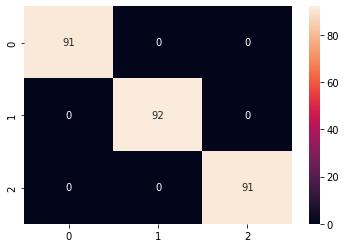

In [8]:
y_preds = model.predict(X_test)
cmap = confusion_matrix(y_test,y_preds)
sb.heatmap(cmap,annot=True)

In [9]:
len(model.estimators_)

80

In [10]:
# from sklearn import tree

# trees = len(model.estimators_)
# cn = ['Low', 'Medium', 'High']

# fig, ax = plt.subplots(trees, 1, figsize=(30,10*trees))

# for i, forest in enumerate(model.estimators_):
#     if trees > 1:
#         tree.plot_tree(forest,
#                        feature_names=X.columns,
#                        class_names=cn,
#                        filled=True,
#                        fontsize=11,
#                        ax=ax[i])
#     else:
#         tree.plot_tree(forest,
#                        feature_names=X.columns,
#                        class_names=cn,
#                        filled=True,
#                        fontsize=11)
    
# plt.tight_layout(h_pad=-10)
# plt.show()


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00        91

    accuracy                           1.00       274
   macro avg       1.00      1.00      1.00       274
weighted avg       1.00      1.00      1.00       274



In [12]:
import joblib
joblib.dump(model,'./rf_model.jb')

['./rf_model.jb']